# `Preprocessing workflow`

#### The preprocessing workflow consists of nine steps:

![Preprocessing.png](images/Preprocessing.png)

##### - `Optional step: Convert Thermo files (*.raw):`

ThermoRawFileParser https://github.com/compomics/ThermoRawFileParser

- It is necessary to convert profile data to centroid mzml. If your files do not originate from a thermo instrument, please convert them using proteowizard (see https://proteowizard.sourceforge.io/) and add them to the "data/mzML/" directory. 

In [1]:
!mono resources/ThermoRawFileParser/ThermoRawFileParser.exe -d="data/raw/" -o="data/mzML/"

/bin/bash: line 1: mono: command not found


Import libraries:

In [2]:
import os
import glob
import sys
import pandas as pd
sys.path.insert(0, '/Users/eeko/openms-develop/openms_build/pyOpenMS')
from pyopenms import *
import shutil

#### `1) PrecursorCorrection` (To the "highest intensity MS1 peak")

This algorithm is used directly after the file introduction, in order to correct any wrong MS1 precursor annotation. For each MS2 spectrum the corresponding MS1 spectrum is determined by using the RT information of the precursor. In the MS1 spectrum, the highest intensity peak is selected as the corrected precursor. We assume that, in a given mass window  (e.g. precursor mass +/- 10 ppm), the precursor with the hightest intensity was actually fragmented (top-n method), which is a method used in the Thermo Orbitrap instrument (Center for Biosustainability).


###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html//classOpenMS_1_1PrecursorCorrection.html#a8acf85ba8b9f249de0369bb083355982 
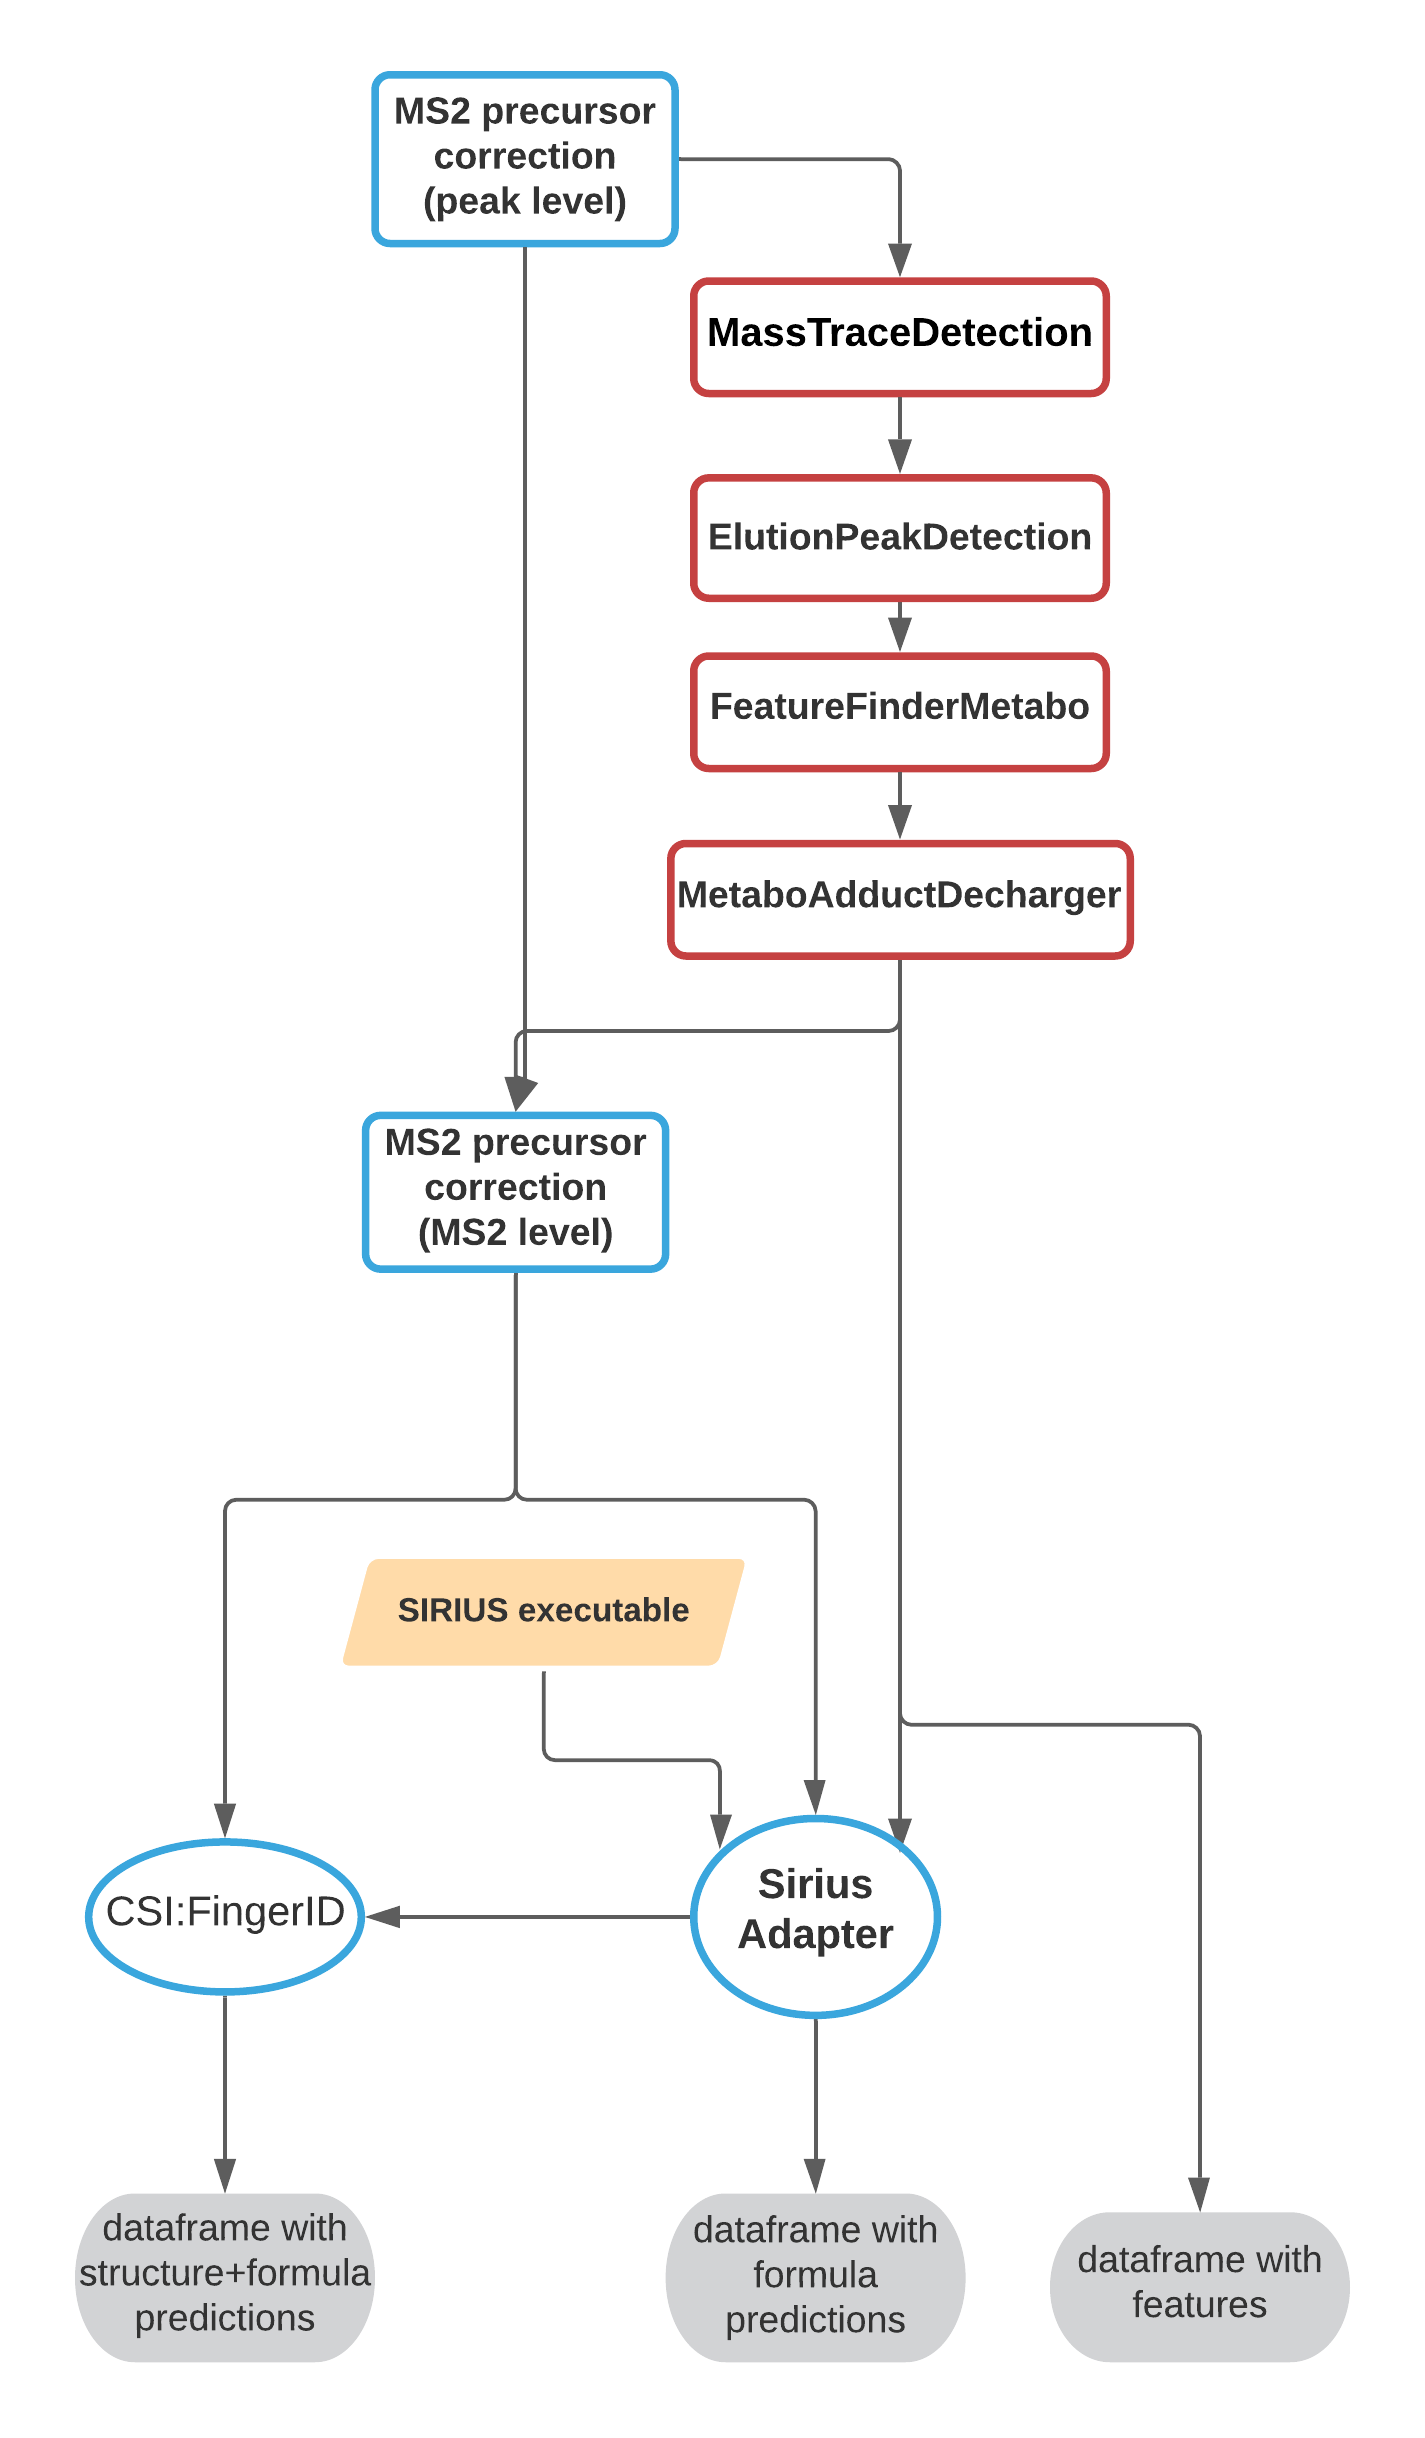

In [3]:
path = os.path.join("results", "interim", "mzML")
try:
    shutil.rmtree(path)
    os.mkdir(path)
except OSError:
    os.mkdir(path)

# input_original_files = glob.glob('data/mzML/*.mzML')
input_original_files = glob.glob('/home/axel/Nextcloud/workspace/Tests/CentogeneWorkflowTest/mzML/*.mzML')

for filename in input_original_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    delta_mzs= []
    mzs = []
    rts= []
    PrecursorCorrection.correctToHighestIntensityMS1Peak(exp, 100.0, True, delta_mzs, mzs, rts)
    mzmlfile_path = os.path.join(path, 'PCpeak_' + os.path.basename(filename))
    MzMLFile().store(mzmlfile_path, exp)

#### `2) Mass trace detection`

A mass trace extraction method that gathers peaks similar in m/z and moving along retention time.
Peaks of a MSExperiment are sorted by their intensity and stored in a list of potential chromatographic apex positions. Only peaks that are above the noise threshold (user-defined) are analyzed and only peaks that are n times above this minimal threshold are considered as apices. This saves computational resources and decreases the noise in the resulting output.
Starting with these, mass traces are extended in- and decreasingly in retention time. During this extension phase, the centroid m/z is computed on-line as an intensity-weighted mean of peaks.
The extension phase ends when either the frequency of gathered peaks drops below a threshold (min_sample_rate, see MassTraceDetection parameters) or when the number of missed scans exceeds a threshold (trace_termination_outliers, see MassTraceDetection parameters).
Finally, only mass traces that pass a filter (a certain minimal and maximal length as well as having the minimal sample rate criterion fulfilled) get added to the result.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MassTraceDetection.html#abff6e392ce6da7af8f083397494a7971



#### `3) Elution peak detection`

Extracts chromatographic peaks from a mass trace.
Mass traces may consist of several consecutively (partly overlapping) eluting peaks, e.g., stemming from (almost) isobaric compounds that are separated by retention time. Especially in metabolomics, isomeric compounds with exactly the same mass but different retentional behaviour may still be contained in the same mass trace. This method first applies smoothing on the mass trace's intensities, then detects local minima/maxima in order to separate the chromatographic peaks from each other. Depending on the "width_filtering" parameters, mass traces are filtered by length in seconds ("fixed" filter) or by quantile.

This method is in other words "deconvolution".

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1ElutionPeakDetection.htmldetails


#### `4) Feature detection`

FeatureFinderMetabo assembles metabolite features from singleton mass traces.
Mass traces alone would allow for further analysis such as metabolite ID or statistical evaluation. However, in general, monoisotopic mass traces are accompanied by satellite C13 peaks and thus may render the analysis more difficult. FeatureFinderMetabo fulfills a further data reduction step by assembling compatible mass traces to metabolite features (that is, all mass traces originating from one metabolite). To this end, multiple metabolite hypotheses are formulated and scored according to how well differences in RT (optional), m/z or intensity ratios match to those of theoretical isotope patterns.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1FeatureFindingMetabo.html

#### `5) Metabolite adduct decharger` 

For each peak, this algorithm reconstructs neutral masses by enumerating all possible adducts with matching charge. You can add the list of adduct files and database files for the algorithm to parse through.
With SIRIUS, an algorithm that is later used, you are only able to use singly charged adducts so charges higher than 1 are filtered out. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_MetaboliteAdductDecharger.html

In [4]:
path = os.path.join("results", "interim", "preprocess")
try:
    shutil.rmtree(path)
    os.mkdir(path)
except OSError:
    os.mkdir(path)

input_mzml_files = glob.glob('results/interim/mzML/PCpeak_*.mzML')

# 2) Mass trace detection

feature_maps_FFM= []
for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

# 3) Elution peak detection (deconvolution)

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
     
    if (epd.getParameters().getValue("width_filtering") == "auto"):
          epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
          mass_traces_final = mass_traces_split

# 4) Feature finding metabo (isotope reduction)
  
    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "true")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm_par.setValue("report_convex_hulls", "true")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])  

    feature_map_filtered = FeatureMap(feature_map_FFM)
    feature_map_filtered.clear(False)

    for f in feature_map_FFM:
        if f.getOverallQuality() > 0.0005:
            feature_map_filtered.push_back(f)

    feature_map_FFM = feature_map_filtered

    feature_maps_FFM.append(feature_map_FFM)

# 5) Adduct annotation

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts", [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
        
    feature_map_MFD = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_map_MFD, cons_map0, cons_map1)
    consensusfile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".consensusXML")
    ConsensusXMLFile().store(consensusfile, cons_map0)
    featurefile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".featureXML")
    FeatureXMLFile().store(featurefile, feature_map_MFD)

Progress of 'mass trace detection':
-- done [took 0.11 s (CPU), 0.11 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.74 s (CPU), 0.10 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.57 s (CPU), 0.08 s (Wall)] -- 
MassExplainer table size: 20
5446 spectra and 1 chromatograms stored.
5236 spectra and 1 chromatograms stored.
Generating Masses with threshold: -6.90776 ...
done
0 of 14 valid net charge compomer results did not pass the feature charge constraints
Inferring edges raised edge count from 18 to 18
Found 18 putative edges (of 47) and avg hit-size of 1
Using solver 'coinor' ...
Optimal solution found!
 Branch and cut took 0.003096 seconds,  with objective value: 0.57.
ILP score is: 0.57
Agreeing charges: 24/24
Progress of 'mass trace detection':
-- done [took 0.04 s (CPU), 0.04 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.43 s (CPU), 0.05 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- do

Display the features in a dataframe

In [5]:
input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))

path = os.path.join("results", "features")
try:
    shutil.rmtree(path)
    os.mkdir(path)
except OSError:
    os.mkdir(path)

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df(export_peptide_identifications=False)
    feature_csv= os.path.join(path, 'features_' + os.path.basename(filename)[4:-10] +"csv")
    DF.to_csv(feature_csv)
print("example:", os.path.basename(filename))
display(DF)

example: MFD_Actino_2.featureXML


,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,
9813187270446306817,1,47.991890,325.112917,45.542578,64.091329,325.112854,327.118195,0.001512,23028250.0
3294180864093191560,1,47.991890,360.150112,45.542578,70.156941,360.147644,362.155762,0.003416,49969400.0
3589062506091211784,1,51.728465,230.095723,47.991890,66.532830,230.093964,231.099014,0.000548,8489444.0
16876938340815820334,1,51.728465,522.203116,46.759929,62.831350,522.200256,524.208435,0.001067,15551020.0
6301448160228557533,1,51.728465,684.256039,46.759929,61.539083,684.250793,686.261597,0.000871,10278490.0
...,...,...,...,...,...,...,...,...,...
1734422599596144332,1,529.425831,432.237931,524.973743,541.496127,432.237793,433.241394,0.001190,17368860.0
13357487689624926099,1,529.425831,437.193213,524.476584,537.063489,437.193115,439.199768,0.000560,8076796.0
15860121724313827919,1,529.425831,460.269269,522.879939,539.911654,460.269226,462.275696,0.001199,16847540.0


#### `6) PrecursorCorrection (To the "nearest feature”)`

This algorithm is used after feature detection and adduct grouping to allow for precursor correction on MS2 level. 

If there are MS2 spectra in the feature space which have been measured in isotope traces, it “corrects” the MS2 spectrum annotation to the monoisotopic trace. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1PrecursorCorrection.html

In [6]:
path = os.path.join("results", "interim", "mzML")

input_mzml_files = sorted(glob.glob('results/interim/mzML/PCpeak_*.mzML'))
input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))

for mzml in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(mzml, exp)
    exp.sortSpectra(True)
    correct = PrecursorCorrection()

    for filename in input_feature_files:
        feature_map_MFD = FeatureMap()
        FeatureXMLFile().load(filename, feature_map_MFD)
        if os.path.basename(mzml)[7:-5] == os.path.basename(filename)[4:-11]:
            correct.correctToNearestFeature(feature_map_MFD, exp, 0.0, 100.0, True, False, False, False, 3, 0)
            corrected_file = os.path.join(path, 'PCfeature_' + os.path.basename(mzml)[7:])
            MzMLFile().store(corrected_file, exp)

#### `7) MapAlignerPoseClustering `
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. The reference file used for Map Alignment is the feature map with the highest number of features.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_MapAlignerPoseClustering.html

In [7]:
path = os.path.join("results", "interim", "preprocess")

input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))
feature_maps=[]
for filename in input_feature_files:
    feature_map_MFD = FeatureMap()
    FeatureXMLFile().load(filename, feature_map_MFD)
    feature_maps.append(feature_map_MFD)

ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()

aligner_par.setValue("max_num_peaks_considered", -1)
aligner_par.setValue("superimposer:mz_pair_max_distance", 0.05)
aligner_par.setValue("pairfinder:distance_MZ:max_difference", 10.0)
aligner_par.setValue("pairfinder:distance_MZ:unit", "ppm")
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value

for feature_map in feature_maps:    
    feature_file = os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
    trafo_file= os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".trafoXML")
    FeatureXMLFile().store(feature_file, feature_map)
    TransformationXMLFile().store(trafo_file, trafo)

Visualisation of data before and after alignment:

/tmp/ipykernel_14282/3299292427.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


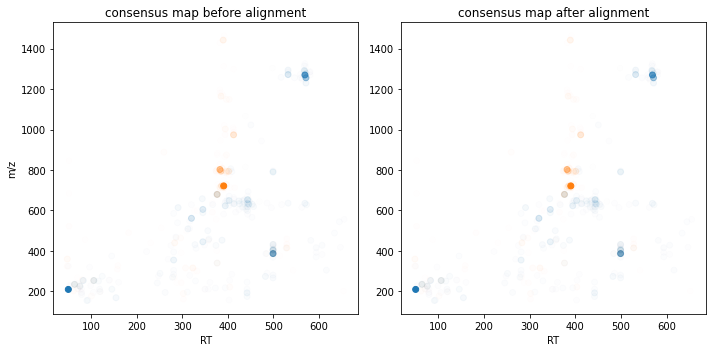

In [8]:
import matplotlib.pyplot as plt
import numpy as np

feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()

#### `8) FeatureGroupingAlgorithmKD `

Feature linker clusters the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [9]:
input_feature_files = sorted(glob.glob('results/interim/preprocess/MapAligned_*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [10]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["sequence"])
# store as tsv file
result.to_csv('results/features/FeatureMatrix.tsv', sep = '\t', index = False)
result

Progress of 'computing RT transformations':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.00 s (CPU), 0.01 s (Wall)] -- 
5446 spectra and 1 chromatograms stored.
5236 spectra and 1 chromatograms stored.
ConsensusXMLFile::store():  found 279 invalid unique ids


,id,charge,RT,mz,quality,Actino_1.mzML,Actino_2.mzML
0,0,1,280.405022,270.192441,0.001054,17964980.0,11669500.0
1,0,1,82.781096,254.161339,0.002696,60417760.0,10477380.0
2,0,1,499.123011,404.206742,0.007360,158875600.0,25170030.0
3,0,1,376.356247,679.511666,0.018334,130825400.0,266171808.0
4,0,1,49.396924,325.112957,0.001048,7802215.0,23028250.0
...,...,...,...,...,...,...,...
273,0,2,332.166475,300.198799,0.001176,0.0,13910090.0
274,0,2,382.045526,802.450834,0.112218,0.0,780350400.0
275,0,2,393.764844,973.902588,0.001994,0.0,10091250.0
276,0,2,390.243280,713.426396,0.005326,0.0,58439320.0


### Split ConsensusMap into features that are complete, and features that have missing values --> requantify only missing features
Reconstruct FeatureMaps from complete ConsensusFeatures, these FeatureMaps will be merged later with the requantification results (FeatureFinderMetaboIdent FeatureMaps) and finally linked.

In [11]:
# split ConsensusMap
consensus_map = ConsensusMap()
ConsensusXMLFile().load(os.path.join(path, 'consensus' + ".consensusXML"), consensus_map)

headers = consensus_map.getColumnHeaders()

complete = ConsensusMap(consensus_map)
complete.clear(False)
missing = ConsensusMap(consensus_map)
missing.clear(False)

for cf in consensus_map:
    if len(cf.getFeatureList()) < len(headers):
        missing.push_back(cf)
    else:
        complete.push_back(cf)

ConsensusXMLFile().store(os.path.join(path, 'consensus_complete' + ".consensusXML"), complete)
ConsensusXMLFile().store(os.path.join(path, 'consensus_missing' + ".consensusXML"), missing)

# reconstruct complete FeatureMaps
consensus_map = ConsensusMap()
ConsensusXMLFile().load(os.path.join(path, 'consensus_complete' + ".consensusXML"), consensus_map)
to_keep_ids = [item for sublist in [[feature.getUniqueId() for feature in cf.getFeatureList()] for cf in consensus_map] for item in sublist]
for fm in feature_maps:
    fm_filterd = FeatureMap(fm)
    fm_filterd.clear(False)
    for f in fm:
        if f.getUniqueId() in to_keep_ids:
            fm_filterd.push_back(f)
    FeatureXMLFile().store(os.path.join("results", "interim", "preprocess", "Complete_" + os.path.basename(fm_filterd.getMetaValue("spectra_data")[0].decode())[7:-4] + "featureXML"), fm_filterd)

ConsensusXMLFile::store():  found 21 invalid unique ids
ConsensusXMLFile::store():  found 259 invalid unique ids


#### `9) MapAlignmentTransformer`
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. Use the trafo XML files from the feature alignment and align the raw spectra.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MapAlignmentTransformer.html

In [12]:
path= "results/interim/Requant"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = sorted(glob.glob('results/interim/mzML/PCpeak_*.mzML'))
input_trafo = sorted(glob.glob('results/interim/preprocess/*.trafoXML'))

for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    transformer = MapAlignmentTransformer()

    for trafo_XML in input_trafo:
        trafo=TransformationDescription()
        TransformationXMLFile().load(trafo_XML, trafo, True)
        if os.path.basename(trafo_XML)[11:-9] == os.path.basename(filename)[7:-5]:
            transformer.transformRetentionTimes(exp, trafo, True)
            mzml_file = os.path.join(path, 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[7:-5] +".mzML")
            MzMLFile().store(mzml_file, exp)

#### `10) FeatureFinderMetaboIdent`
This algorithm detects and extracts MS1 data that match the feature list in the metabolite identification table.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_FeatureFinderMetaboIdent.html

In [13]:
#Import the consensus tsv table and keep only the columns: RT, mz and charge
consensus_map = ConsensusMap()
ConsensusXMLFile().load(os.path.join("results", "interim", "preprocess", "consensus_missing.consensusXML"), consensus_map)
library = consensus_map.get_df()[['RT','mz', "charge"]]
#convert the mz and RT columns to floats and charge to integer for calculations
library["charge"] = pd.to_numeric(library["charge"], downcast="integer")
library["mz"] = pd.to_numeric(library["mz"], downcast="float")
library["RT"] = pd.to_numeric(library["RT"], downcast="float")
library= library.rename(columns={"RT": "RetentionTime", "charge":"Charge"})
#Add a columns named "Mass" and calculate the neutral masses from the charge and mz:
library["Mass"] = 0.0
for i in library.index:
    library.at[i, "Mass"] = (library.loc[i, "mz"] * library.loc[i, "Charge"]) - (library.loc[i, "Charge"] * 1.007825)
#drop the mz column
library= library.drop(columns= "mz")
library["Charge"] = [[c] for c in library["Charge"]]
library["RetentionTime"] = [[rt] for rt in library["RetentionTime"]]
#add the rest of the columns required for the MetaboliteIdentificationTable and fill with zeros or blanks, except the "Compound Name"
#which, since they are all unknown, can be filled with f_#
library['CompoundName'] = [i for i in range(0,len(library))]
library['CompoundName'] = "f_" + library['CompoundName'].astype(str)
library["SumFormula"] = ""
library["RetentionTimeRange"]= [[0.0] for _ in range(len(library.index))]
library["IsoDistribution"]= [[0.0] for _ in range(len(library.index))]
library = library[["CompoundName","SumFormula", "Mass","Charge","RetentionTime","RetentionTimeRange", "IsoDistribution"]]
library_reformatted = []
for _, row in library.iterrows():
    library_reformatted.append(FeatureFinderMetaboIdentCompound(row["CompoundName"], row["SumFormula"], row["Mass"], row["Charge"], row["RetentionTime"], row["RetentionTimeRange"], row["IsoDistribution"]))

library.to_csv("resources/MetaboliteIdentification.tsv", sep="\t", index= None)
library

,CompoundName,SumFormula,Mass,Charge,RetentionTime,RetentionTimeRange,IsoDistribution
id,,,,,,,
0,f_0,,1254.592639,[1],[546.3882446289062],[0.0],[0.0]
0,f_1,,368.161914,[1],[499.3102722167969],[0.0],[0.0]
0,f_2,,631.285205,[1],[453.1125793457031],[0.0],[0.0]
0,f_3,,209.071628,[1],[50.257965087890625],[0.0],[0.0]
0,f_4,,227.137622,[1],[54.02669906616211],[0.0],[0.0]
...,...,...,...,...,...,...,...
0,f_253,,598.381933,[2],[332.1664733886719],[0.0],[0.0]
0,f_254,,1602.885961,[2],[382.0455322265625],[0.0],[0.0]
0,f_255,,1945.789526,[2],[393.76483154296875],[0.0],[0.0]


In [15]:
input_mzml_files=sorted(glob.glob("results/interim/Requant/*.mzML"))
path = "results/interim/Requant"
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(library_reformatted, fm, String(mzml_file))

    # save FeatureMap to file
    ff_file = os.path.join(path, 'FFMID_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

5446 spectra and 1 chromatograms stored.
5236 spectra and 1 chromatograms stored.
RT window size calculated as 240 seconds.


ValueError: invalid literal for int() with base 10: '[1]'

### Merge complete FeatureMaps from FFM with requantified FeatureMaps from FFMID

In [ ]:
for file_ffm in glob.glob("results/interim/preprocess/Complete_*.featureXML"):
    for file_ffmid in glob.glob("results/interim/Requant/FFMID_*.featureXML"):
        if os.path.basename(file_ffm)[9:] == os.path.basename(file_ffmid)[6:]:
            fm_ffm = FeatureMap()
            FeatureXMLFile().load(file_ffm, fm_ffm)
            fm_ffmid = FeatureMap()
            FeatureXMLFile().load(file_ffmid, fm_ffmid)
            for f in fm_ffmid:
                fm_ffm.push_back(f)
            fm_ffm.setUniqueIds()
            FeatureXMLFile().store(os.path.join("results", "interim", "Requant", "Merged_" + os.path.basename(file_ffm)[9:]), fm_ffm)

#### `11) FeatureGroupingAlgorithmKD `

Feature linker clusters the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [ ]:
input_feature_files = sorted(glob.glob('results/interim/Requant/Merged_*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [ ]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["sequence"])
# store as tsv file
result.to_csv('results/features/FeatureMatrix_Requantified.tsv', sep = '\t', index = False)
result

Progress of 'computing RT transformations':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 
ConsensusXMLFile::store():  found 289 invalid unique ids


,id,charge,RT,mz,quality,Actino_2.mzML,Actino_1.mzML
0,0,1,294.366151,464.259644,4.187579,3.611760e+07,9.462992e+04
1,0,1,345.363748,605.220094,4.159199,8.423018e+05,1.281181e+08
2,0,1,606.326200,383.242341,4.554430,4.958348e+04,9.615725e+06
3,0,1,498.959430,425.135712,4.675897,2.333083e+06,1.106734e+07
4,0,1,592.888275,393.224305,4.575469,9.011021e+04,1.098738e+07
...,...,...,...,...,...,...,...
283,0,2,389.933102,721.424012,4.531744,1.969058e+09,0.000000e+00
284,0,2,395.930359,728.431397,4.699428,5.232181e+07,0.000000e+00
285,0,1,390.841794,1463.821717,4.325231,5.085424e+06,0.000000e+00
286,0,2,392.959987,866.473206,4.568506,6.357370e+06,0.000000e+00


Compare the preprocessed to the requantified:

In [ ]:
Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*.csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)

    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)

        if os.path.basename(table)== os.path.basename(matrix):
            print(os.path.basename(matrix))
            print("Preprocessed:", feature_no, "Requantified:", requant_no)
